# Assignment — Graph partitioning

In [1]:
import matplotlib.pyplot as plt
import requests
from scipy.cluster.hierarchy import dendrogram, linkage
import networkx as nx
from scipy.spatial.distance import squareform
from zlib import adler32
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
from sklearn import datasets
import numpy as np
import itertools
from networkx.algorithms import community
from sklearn.neighbors import kneighbors_graph
import math

Let us try to detect communities in Les Miserables graph.

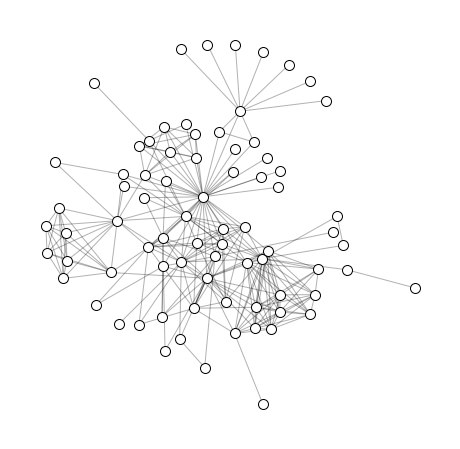

In [2]:
G = nx.Graph(nx.les_miserables_graph().edges)
G = nx.convert_node_labels_to_integers(G)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 1. Girvan Newman algorithm, edge betweennes (2 points)

Let us apply Girvan Newman algorithm with edge betweenness. The idea is we cut edges with highest betweenness until the graph becomes disconnected. Use `nx.algorithms.community.girvan_newman` to find communities.

Write a function `edge_betweenness` that takes a graph and the number of divisions and returns np.array of (integer) labels of nodes in each iteration. The shape of the output is [n, m] where n is a number of iteration and m is a number of nodes.

In [3]:
def edge_betweenness(G, n):
  comp = community.girvan_newman(G)
  labels = np.zeros((n,len(G.nodes)))
  row = 0
  for communities in itertools.islice(comp, n):
    #print(tuple(sorted(c) for c in communities))
    int_label = 1
    for c in communities:
      #int_label = 1
      for node in sorted(c):
        labels[row][node] = int_label
      int_label = int_label + 1
    row = row +1 
  return labels
    #print(tuple(sorted(c) for c in communities))
    # YOUR CODE HERE
    #raise NotImplementedError()

In [4]:
labels = edge_betweenness(G, 6)
assert labels.shape == (6, 77)
assert np.unique(labels[0]).shape == (2,)
assert np.unique(labels[0]).shape[0] < np.unique(labels[1]).shape[0] < np.unique(labels[5]).shape[0]
assert labels[5][22] == labels[5][23]
assert labels[5][31] == labels[5][34]

Let us draw Girvan Newman algorithm step-by-step.

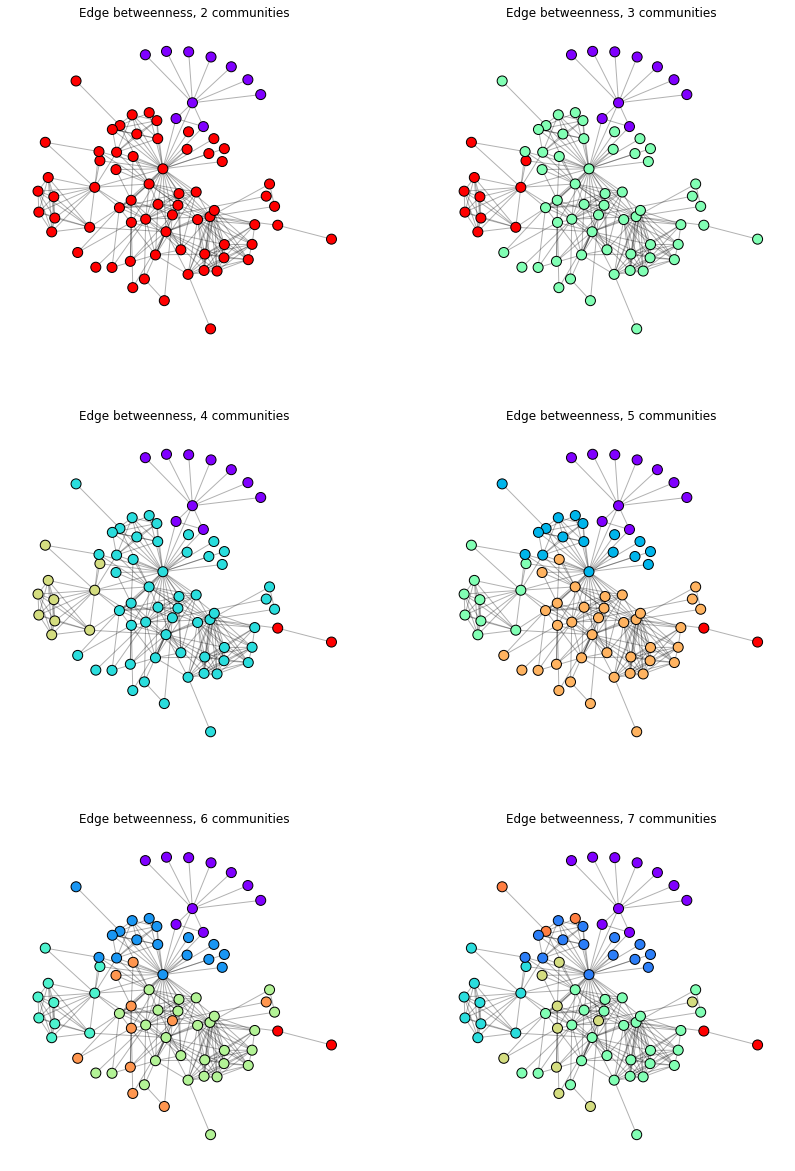

In [5]:
plt.figure(figsize=(7*2, 7*3))
colors = edge_betweenness(G, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

### Task 2. Modularity  (2 points)

One of the best-known methods for community detection is called modularity. 

$$M = \frac{1}{2m}\sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m} \right) \delta(c_i, c_j)$$

where $m$ is the number of edges and $\delta(c_i, c_j)$ is Kronecker delta, it is equal 1 if nodes belong to the same community and 0 otherwise. Modularity is based on expected number of edges between nodes in Configuration model


$$\frac{k_ik_j}{2m-1} \approx \frac{k_ik_j}{2m}$$

<img src='http://networksciencebook.com/images/ch-04/figure-4-15.jpg' width=400>

Indeed, $k_i$ stubs can be connected to $k_j$ stubs between nodes $i$ and $j$ and there are $2m - 1$ ways to connect a stub for any other stub that can be approximated by $2m$ in a large network. That is, modularity measures the difference between expected number of edges and actual number of edges between nodes — the large modularity, the better partitioning. Let us implement modularity calculation.

`modularity` function takes an adjacency matrix and list of lists of nodes that belong to the same community and returns modularity score.

In [6]:
def modularity(A, communities):
    m = A.sum() / 2
    res = (A - expected_edges(A, m)) * kronecker(A, communities)
    return res.sum() / 2 / m

Write a function `expected_edges` that takes an adjacency matrix and number of edges `m` and returns a np.array with expected number of edges.

In [7]:
def expected_edges(A, m):
    row,col = A.shape
    ee = np.zeros((row,col))
    for i in range(0,row):
      for j in range(0, col):
        k_i = A[i].sum()
        k_j = A[j].sum()
        ee[i][j] = k_i*k_j /(2*m)
    return ee
    # YOUR CODE HERE
    #raise NotImplementedError()

In [8]:
A = nx.to_numpy_array(G)
m = G.number_of_edges()
ee = expected_edges(A, m)
assert ee.shape == A.shape
assert np.all(0 <= ee)
assert round(ee[10, 10], 2) == round(G.degree[10] * G.degree[10] / 2 / m, 2)

Write a function `kronecked` that takes an adjacency matrix and list of lists of nodes that belong to the same community and returns a np.array with Kronecked delta.

In [9]:
def kronecker(A, communities):
  row,col = A.shape
  kr = np.zeros((row,col))
  for i in range(0,row):
    i_com = [com for com in communities if i in com][0]
    #print(i_com)
    for j in range(0, col):
      if j in i_com:
        kr[i][j] = 1
  return kr
    # YOUR CODE HERE
    #raise NotImplementedError()

In [10]:
A = nx.to_numpy_array(G)
communities = [np.arange(0, 10), np.arange(10, len(G))]
kd = kronecker(A, communities)
assert kd.shape == A.shape
assert kd[0, 9] == 1 and kd[10, 11] == 1
assert kd[0, 10] == 0

Write a function `edge_betw_modularity` that takes a graph, number of iterations of Girvan Newman algorithm and returns a np.array with modularity after each iteration.

In [11]:
def edge_betw_modularity(G, n):
  comp = community.girvan_newman(G)
  labels = np.zeros((n,))
  A = nx.to_numpy_array(G)
  row = 0
  for communities in itertools.islice(comp, n):
    mod = modularity(A , communities)
    labels[row] = mod
    row = row +1 
  return labels
    # YOUR CODE HERE
    #raise NotImplementedError()

In [12]:
n_iterations = 20
mod_val = edge_betw_modularity(G, n_iterations)
assert mod_val.shape == (n_iterations, )
assert round(mod_val[0], 4) == 0.0746
assert round(mod_val[7], 4) == 0.4519

Let us draw dependency between a number of iteration and modularity.

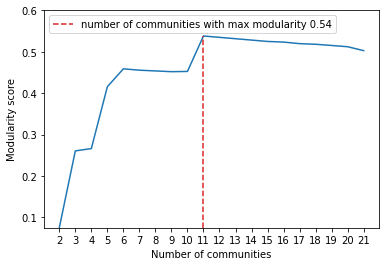

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, mod_val)
best_n = np.argmax(mod_val) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(mod_val))
plt.plot(
    [best_n, best_n], [min(mod_val), max(mod_val)], 
    linestyle='--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.xticks(np.arange(n_iterations)+2)
plt.ylim((mod_val.min(), 0.6))
plt.show()

### Task 3. Eigenvalues of graph Laplacian (2 points)

There are a few auxiliary methods for graph generation.

In [14]:
def ring_lattice(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [15]:
def pair_graph(n):
    G = nx.disjoint_union(nx.complete_graph(n), nx.complete_graph(n))
    G.add_edge(0, n)
    return G

In [16]:
def triple_graph(n):
    G = nx.disjoint_union_all(
        [nx.complete_graph(n), nx.complete_graph(n), nx.complete_graph(n)]
    )
    G.add_edge(0, n)
    G.add_edge(n, n*2)
    G.add_edge(n*2, 0)
    return G

Graph Laplacian is

$$L = D - A$$

where $A$ is an adjacency matrix and $D$ is a diagonal matrix with node degrees. Eigenvalues and eigenvectors of Laplacian can give us information about structure of a graph. Let us see a few simple examples.

Write a function `eig_laplacian` that takes a graph and returns a tuple with 2 np.arrays: eigenvectors and eigenvalues of Laplacian. The both are ordered in ascending of eigenvalues. 

_Hints: any symmetric matrix has only real eigenvalues and eigenvectors. You can use `np.linalg.eigh` to calculate eigenvectors and eigenvalues in a symmetric matrix._

In [17]:
def eig_laplacian(G):
    A = nx.to_numpy_array(G)
    D = np.zeros(A.shape)
    for node in G.nodes:
      D[node][node] = G.degree(node)
    L = D-A
    val , vect = np.linalg.eigh(L)
    return vect,val
    # YOUR CODE HERE
    #raise NotImplementedError()

In [18]:
emptyG = nx.empty_graph(10)
vecs, vals = eig_laplacian(emptyG)
assert vecs.sum() == 10
assert vals.sum() == 0
oneedgeG = nx.empty_graph(10)
oneedgeG.add_edge(0, 1)
vecs, vals = eig_laplacian(oneedgeG)
assert abs(vecs.round(4)[0, -1]) == abs(vecs.round(4)[1, -1]) == 0.7071
assert vals[0] < vals[-1]
vecs, vals = eig_laplacian(nx.complete_graph(10))
assert (vals == vals.real).sum() == vals.shape[0]
assert (vecs == vecs.real).sum() == vals.shape[0]**2
vecs, vals = eig_laplacian(ring_lattice(10, 2))
assert adler32(vals.round(4)[-1]) == 6815825
assert adler32(vals.round(4)[-2]) == 393479360

Consider some simple graphs and their Laplacian eigenvalues.

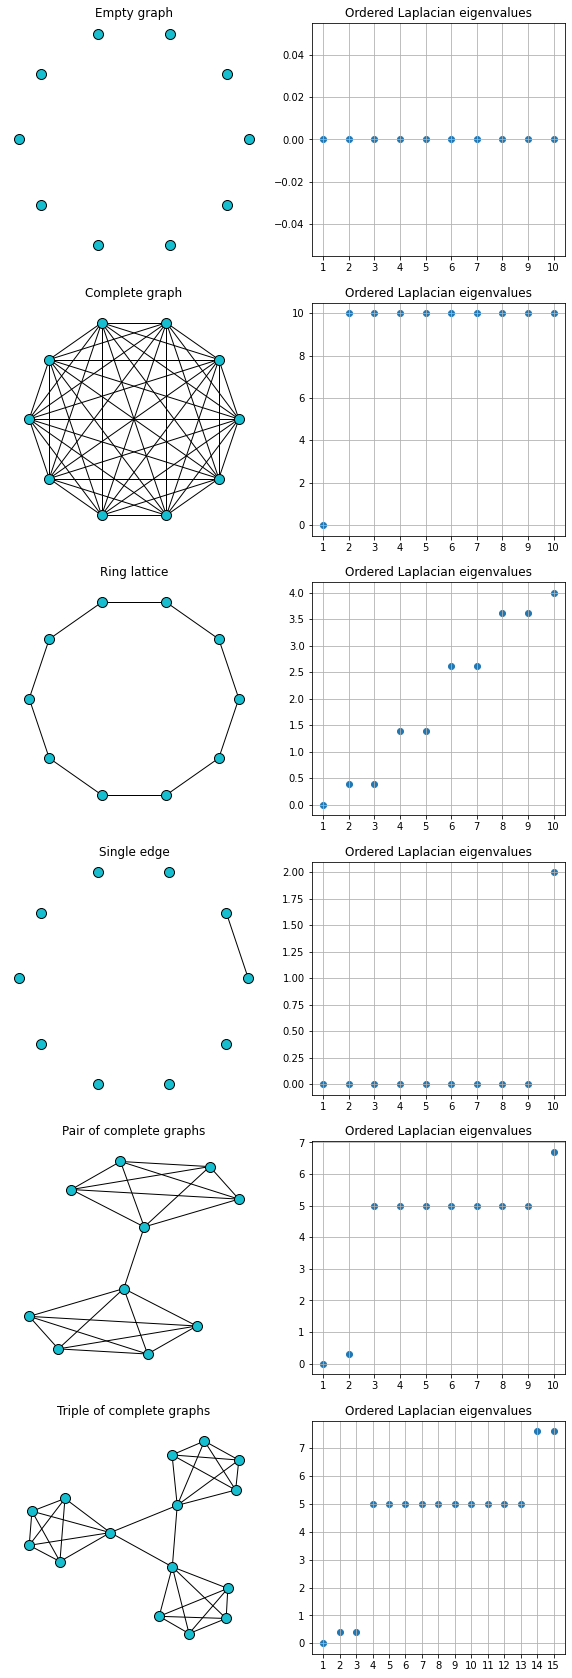

In [19]:
cases = []
cases.append([emptyG, 'Empty graph', nx.draw_circular])
cases.append([nx.complete_graph(10), 'Complete graph', nx.draw_circular])
cases.append([ring_lattice(10, 2), 'Ring lattice', nx.draw_circular])
cases.append([oneedgeG, 'Single edge', nx.draw_circular])
cases.append([pair_graph(5), 'Pair of complete graphs', nx.draw_kamada_kawai])
cases.append([triple_graph(5), 'Triple of complete graphs', nx.draw_kamada_kawai])

plt.figure(figsize=(5*2, 5*6))
i = 1
for iterG, title, designer in cases:
    plt.subplot(6, 2, i)
    i += 1
    designer(iterG, 
             node_color='tab:cyan', 
             edgecolors='black', 
             node_size=100)
    plt.title(title)
    plt.subplot(6, 2, i)
    i += 1
    vecs, vals = eig_laplacian(iterG)
    plt.scatter(np.arange(1, len(iterG) + 1), vals)
    plt.grid()
    plt.xticks(np.arange(1, len(iterG) + 1))
    plt.title('Ordered Laplacian eigenvalues')

We can observe that a number of zero eigenvalues is a number of connected component. $\lambda_2 = n$ in a complete graph. Also, the largest gap between eigenvalues indicates an optimal number of clusters. For example, the largest gap in a complete graph is between 1 and 2, then an optimal number of clusters is 1. Similarly, 2-3 gap is related to a pair graph, and 3-4 gap is related to a triple graph.

### Task 4. Spectral clustering (2 points)

Spectral clustering is a very powerful algorithm for community detection that minimize graph cuts. It is based on Laplacian eigenvectors, in particular a sign of the second smallest eigenvector determines the partition of a graph into two clusters. Consider the following artificial dataset.

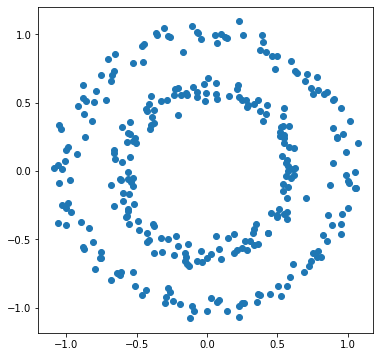

In [88]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1])
plt.show()

Let us isolate data points in center circle using spectral clustering. Any distance based dataset can be represented as a graph with edges between neighbors.

Write a function `custom_graph` that takes a np.array with x-y data points and returns a connected graph. 

_Hint: try to apply `sklearn.neighbors.kneighbors_graph`._

_Remark: you can introduce your own distance_

In [89]:
def radius_metric(first_point , second_point):
  return math.sqrt((first_point[0]-second_point[0])**2+(first_point[1]-second_point[1])**2)

In [90]:
def r_metric(first_point):
  return math.sqrt((first_point[0])**2+(first_point[1])**2)

In [91]:
def circular_metric(first_point , second_point):
  first_r = math.sqrt((first_point[0])**2+(first_point[1])**2)
  second_r = math.sqrt((second_point[0])**2+(second_point[1])**2)
  d = 0
  if (first_r> second_r ):
    tmp = second_r/first_r
    if (tmp >0.5):
      d = math.sqrt((first_point[0]-second_point[0])**2+(first_point[1]-second_point[1])**2)+ second_r
    else:
      d =  math.sqrt((first_point[0]-second_point[0])**2+(first_point[1]-second_point[1])**2)
  else:
    tmp = first_r/second_r
    if (tmp >0.5):
      d = math.sqrt((first_point[0]-second_point[0])**2+(first_point[1]-second_point[1])**2)+ first_r
    else:
      d =  math.sqrt((first_point[0]-second_point[0])**2+(first_point[1]-second_point[1])**2)
  return d

In [92]:
def custom_graph(data):
  #A = kneighbors_graph(data, 10, mode='distance', metric= radius_metric)
  #A = kneighbors_graph(data, 8)
  #A = kneighbors_graph(data/, 10, mode='distance', metric= 'haversine')
  #print(A.toarray())
  #print(np.count_nonzero(A.toarray()))
  #A = kneighbors_graph(data, 2, mode='distance', metric= circular_metric)
  A = kneighbors_graph(data, 10, mode='distance', metric= circular_metric)
  G = nx.from_numpy_array(A.toarray())
  return G
    # YOUR CODE HERE
    #raise NotImplementedError()

In [93]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
assert circlesG.number_of_nodes() == 300
assert nx.is_connected(circlesG)

In [94]:
circles

array([[-0.39786524,  0.33805579],
       [-0.06993888,  0.57797741],
       [ 0.85140506,  0.57823028],
       [-0.54412658,  0.10443881],
       [-0.56102452, -0.28981678],
       [ 0.78291047, -0.6306301 ],
       [-0.52748707, -0.10889988],
       [-0.37375506,  0.44461999],
       [-0.52787204,  0.78859793],
       [-0.23909346, -0.94820752],
       [ 0.50795679, -0.27851947],
       [ 0.78624037,  0.58865921],
       [ 0.06995012,  0.52481584],
       [-0.37460906, -0.60385968],
       [ 0.63586069,  0.71642704],
       [-1.054342  ,  0.04448391],
       [ 0.14843205, -0.49348318],
       [-0.87365984, -0.57443271],
       [-0.59356176, -0.15846592],
       [ 0.52591658,  0.32345761],
       [-0.02412755,  0.63788834],
       [-0.27935379, -0.85503675],
       [ 0.44483694, -0.89817254],
       [ 0.69240697, -0.73775006],
       [-0.56326224, -0.00564786],
       [ 0.14486672, -1.02617388],
       [-0.14735566,  0.57299002],
       [ 0.54526169, -0.31617402],
       [-0.51854949,

Let us draw values in second smallest eigenvector of Laplacian.

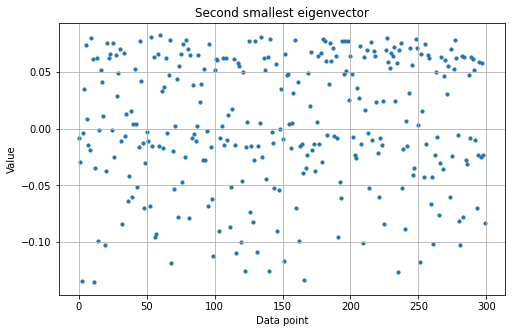

In [95]:
vecs, vals = eig_laplacian(circlesG)

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(300), vecs[:, 1], s=10)
plt.title('Second smallest eigenvector')
plt.xlabel('Data point')
plt.ylabel('Value')
plt.grid()
plt.show()

Next, write a function `spectral_two_clusters` that takes np.array with ordered eigenvectors and returns np.array with labels of nodes.

In [148]:
def spectral_two_clusters(vecs):
    #sec_smallest = vecs[len(vecs)-2]
    sec_smallest = vecs[:,1]
    labels = np.zeros(sec_smallest.shape)
    i = 0
    for node in sec_smallest:
      if node > 0:
        labels[i] = 0
      else:
        labels[i] = 1
      i= i+1
    return labels

    # YOUR CODE HERE
    #raise NotImplementedError()

In [100]:
#circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
#circlesG = custom_graph(circles)
#vecs, vals = eig_laplacian(circlesG)
#vecs
#labels = spectral_two_clusters(vecs)
#print(labels)
#print(truth_labels)
#abs(np.corrcoef(truth_labels, labels)[0, 1])


[0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
[1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1
 1 1 0 1 0 

0.06669038301984187

In [149]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
vecs, vals = eig_laplacian(circlesG)
labels = spectral_two_clusters(vecs)

assert abs(np.corrcoef(truth_labels, labels)[0, 1]) > 0.95

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

AssertionError: ignored

_Remark: there are two directions of graph construction: selection pairs of nodes to connect to each other, and choosing the weights of created edges. Set `factor=0.7` in `datasets.make_circles` and test yourself — try to achive 0.9 correlation. Combine `sklearn.neighbors.kneighbors_graph` with `scipy.spatial.distance_matrix` or `sklearn.metrics.pairwise.rbf_kernel`. Details are [here](http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf)._

### Task 5. Laplacian Eigenmaps (2 points)

In the previous task, we saw how to split a graph into two parts. Let us consider a way to get more parts in the following graph.

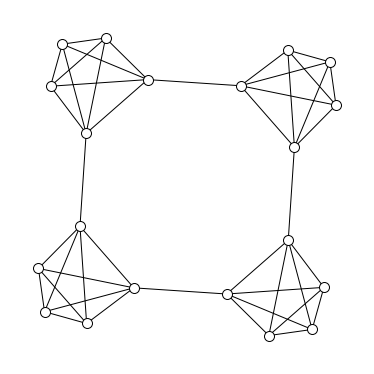

In [138]:
quadG = nx.disjoint_union_all([nx.complete_graph(5), 
                               nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5)])
quadG.add_edge(0, 5)
quadG.add_edge(6, 10)
quadG.add_edge(11, 16)
quadG.add_edge(17, 1)

plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    node_color='white', 
    edgecolors='black', 
    node_size=100)

Further splitting can be performed by different approaches. For example, we can repeat the clustering procedure on the both subgraphs separetely and choose a minimal graph cut and then repeat it again. Another way is to get Laplacian Eigenmaps and then apply KMeans. Let us consider how it works.

1. Compute _normalized_ Laplacian
$$L = D^{-1/2}(D - A)D^{-1/2}$$
2. Find the $K$ smallest eigenvectors (excluding the smallest)
3. Form the Laplacian eigenmaps — a matrix where columns are eigenvectors, rows are node embeddings
4. Put eigenmaps into KMeans
5. Label nodes by fitted KMeans

Write a function `norm_laplacian` that takes an adjacency matrix `A` and returns a normalized Laplacian.

In [139]:
def norm_laplacian(A):
    D = np.zeros(A.shape)
    D_root = np.zeros(A.shape)
    #L = np.zeros(A.shape)
    row , column = A.shape
    for i in range(0,row):
      degree = np.sum(A[i], dtype=np.int32)
      D[i][i] = degree
      if (degree != 0):
        D_root[i][i] = 1/math.sqrt(degree)
    #L = np.dot(D_root,np.dot(D-A,D_root))
    L = np.dot(np.dot(D_root,D-A),D_root)
    #D_root *(D-A)*D_root
    return L

       


    

In [140]:
A = nx.to_numpy_array(quadG)
L = norm_laplacian(A)
assert L.shape == (20, 20)
assert np.diagonal(L).sum() == 20
assert round(L[:, 2].sum(), 4) == 0.0528

Write a function `spectral_embedding` that takes np.array with normalized Laplacian and returns np.array with Laplacian Eigenmaps. `n_components` is a number of vectors of the output.

In [141]:
def spectral_embedding(L, n_components):
    val , vect = np.linalg.eigh(L)
    row , column = L.shape
    LE = np.zeros((row,n_components))
    j = 0 
    for col in range(1,n_components+1):
      i = 0
      for item in vect[:,col]:
        LE[i][j] = item
        i = i +1
      j = j+1
    return LE
    #return vect,val
    # YOUR CODE HERE
    #raise NotImplementedError()

In [142]:
embedding = spectral_embedding(L, 3)
assert embedding.shape == (20, 3)
assert embedding[:, 0].max() > 0
assert embedding[:, 0].min() < 0
assert embedding[:, 1].max() > 0
assert embedding[:, 1].min() < 0
assert (embedding[:, 0] > 0).sum() == 10
assert (embedding[:, 1] > 0).sum() == 10
assert (embedding[:, 2] > 0).sum() == 10

Let us look at a pairplot of the spectral embedding.

In [143]:
def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L = norm_laplacian(A)
    embedding = spectral_embedding(L, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [144]:
embedding = spectral_embedding(L, 3)
labels = spectral_clustering(quadG, 4, 3)
assert np.all(labels[:5] == labels[0])
assert np.all(labels[5:10] == labels[5])
assert np.all(labels[10:15] == labels[10])
assert np.all(labels[15:20] == labels[15])

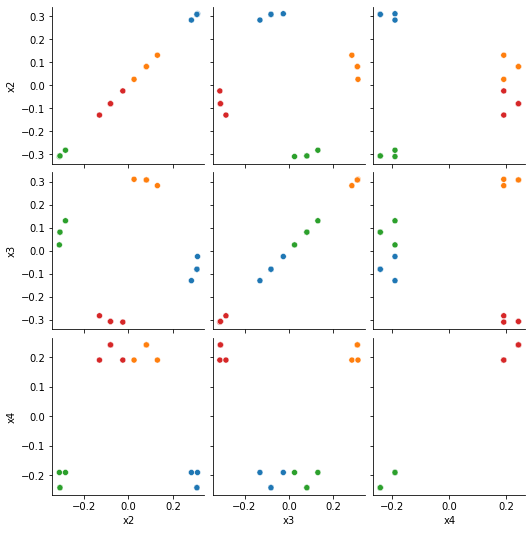

In [145]:
embedding = spectral_embedding(L, 3)
labels = spectral_clustering(quadG, 4, 3)
pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label'])
pair_data.label = pair_data.label.astype('str')
p = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)
p._legend.remove()
plt.show()

We can see four distinct clusters in the plots, that is why we use KMeans, but other clustering algorithms can also be applied here.

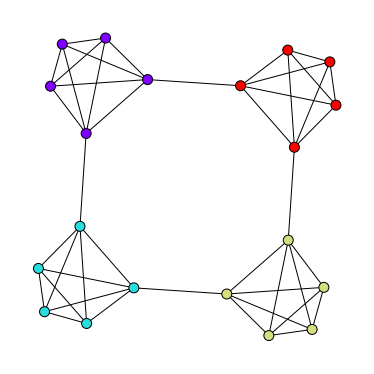

In [146]:
plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100)

Finally, let us see how spectral clustering works on the Les Miserables graph.

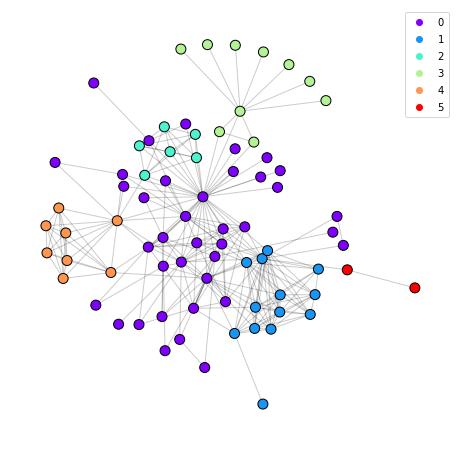

In [147]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(G, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements())
plt.show()